# Explore Effect Size of Predictions

In [46]:
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

DIR="../data/xtra-berlin"
WID=15

times = pd.read_csv(f"{DIR}/eval-alltimes.csv.gz")
fe_cols = [c for c in times.columns if c.endswith('_fe')]
times = times.drop(columns=[c[:-3] for c in fe_cols]) # drop non-fe times
times.columns = [c.replace("_fe","") for c in times.columns]
times

,ID,split,cycle,time_combi,time_f2f,time_f2fsr,time_sumpb,time_vbc,time_vwc,time_sbc,time_def
0,bacp/bacp-m1-05-c18-xcsp2018.param,class,10,1.063,2.521,0.980,1.063,0.863,1.547,0.993,0.997
1,bacp/bacp-m1-06-c18-xcsp2018.param,class,10,1.572,2.842,1.572,1.572,1.256,2.214,1.460,1.379
2,bacp/bacp-m1-07a-c18-xcsp2018.param,class,10,243.819,245.151,243.819,597.534,176.584,1106.291,235.787,615.141
3,bacp/bacp-m1-07a-c18-xcsp2018.param,instance,10,282.220,283.552,282.220,282.220,176.584,1106.291,235.787,615.141
4,bacp/bacp-m1-07b-c18-xcsp2018.param,class,10,3277.412,3278.751,3277.412,36000.151,1744.499,36000.000,3326.558,36000.000
...,...,...,...,...,...,...,...,...,...,...,...
13198,langford/langford_4_16.param,class,9,9.671,10.858,9.671,9.671,8.589,50.331,14.681,8.589
13199,langford/langford_6_12.param,class,9,1.157,2.468,1.157,1.157,0.894,9.426,1.388,0.944
13200,langford/langford_6_16.param,class,9,2.059,3.727,2.059,2.059,1.500,36000.000,2.825,1.694
13201,langford/langford_6_16.param,instance,9,2.059,3.727,2.059,2.059,1.500,36000.000,2.825,1.694


In [47]:
import scipy.stats as stats

t = times.loc[times.split=='class',['cycle','time_sbc','time_sumpb']]
#print(t)
t_means = t.groupby(['cycle']).mean().reset_index()
#print(t_means)
result = stats.wilcoxon(t_means.time_sumpb,t_means.time_sbc)
s = result.statistic
p = result.pvalue
print(dir(result))
print(result)

['__add__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getnewargs_ex__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_asdict', '_extra_fields', '_fields', 'count', 'index', 'pvalue', 'statistic']
WilcoxonResult(statistic=240.0, pvalue=6.508990648690371e-05)


## Define Vargha-Delaney's A Test

In [48]:
def vda_effect(dist1, dist2):
    ''' 
    Implementation of Vargha-Delaney's A test, a non-parametric
    effect magnitude test. The distributions may be of different
    sizes in this implementation. 
    '''
    equal = greater = 0.0
    for x,y in it.product(dist1, dist2):
        equal += (1 if x==y else 0)
        greater += (1 if x>y else 0)
    nm = len(dist1) * len(dist2)    
    return (greater / nm) + ((0.5 * equal) / nm)

## Calculate Test Values Per Cycle

In [49]:
t_cols = [f"time_{x}" for x in ('vbc', 'sbc', 'def', 'f2f', 'f2fsr', 'sumpb', 'combi')]
splits = ['class','instance']
means_by_cycle = times.groupby(['split','cycle'])[t_cols].mean()
effects   = {s:np.zeros(tuple([len(t_cols)]*2)) for s in splits}
wsr_p_val = {s:np.zeros(tuple([len(t_cols)]*2)) for s in splits}
wsr_rbc   = {s:np.zeros(tuple([len(t_cols)]*2)) for s in splits}
wsr_cles   = {s:np.zeros(tuple([len(t_cols)]*2)) for s in splits}
wsr_w_val = {s:np.zeros(tuple([len(t_cols)]*2)) for s in splits}

for i, j, split in it.product(range(len(t_cols)),range(len(t_cols)),splits):
    a,b = t_cols[i],t_cols[j]
    t = means_by_cycle.query(f"split=='{split}'")
    effects[split][i,j] = vda_effect(t[a],t[b])
    wsr_df = pg.wilcoxon(t[a],t[b]) if a!=b else None
    if wsr_df is not None:
        wsr_w_val[split][i,j] = wsr_df.iloc[0]['W-val']
        wsr_p_val[split][i,j] = wsr_df.iloc[0]['p-val']
        wsr_rbc[split][i,j] = wsr_df.iloc[0]['RBC']
        wsr_cles[split][i,j] = wsr_df.iloc[0]['CLES']

print(wsr_w_val['class'])

[[  0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 629. 336. 456. 240. 255.]
 [  0. 629.   0. 436. 369. 201. 196.]
 [  0. 336. 436.   0. 609. 363. 440.]
 [  0. 456. 369. 609.   0. 265. 356.]
 [  0. 240. 201. 363. 265.   0. 551.]
 [  0. 255. 196. 440. 356. 551.   0.]]


## V-D A Effect Size

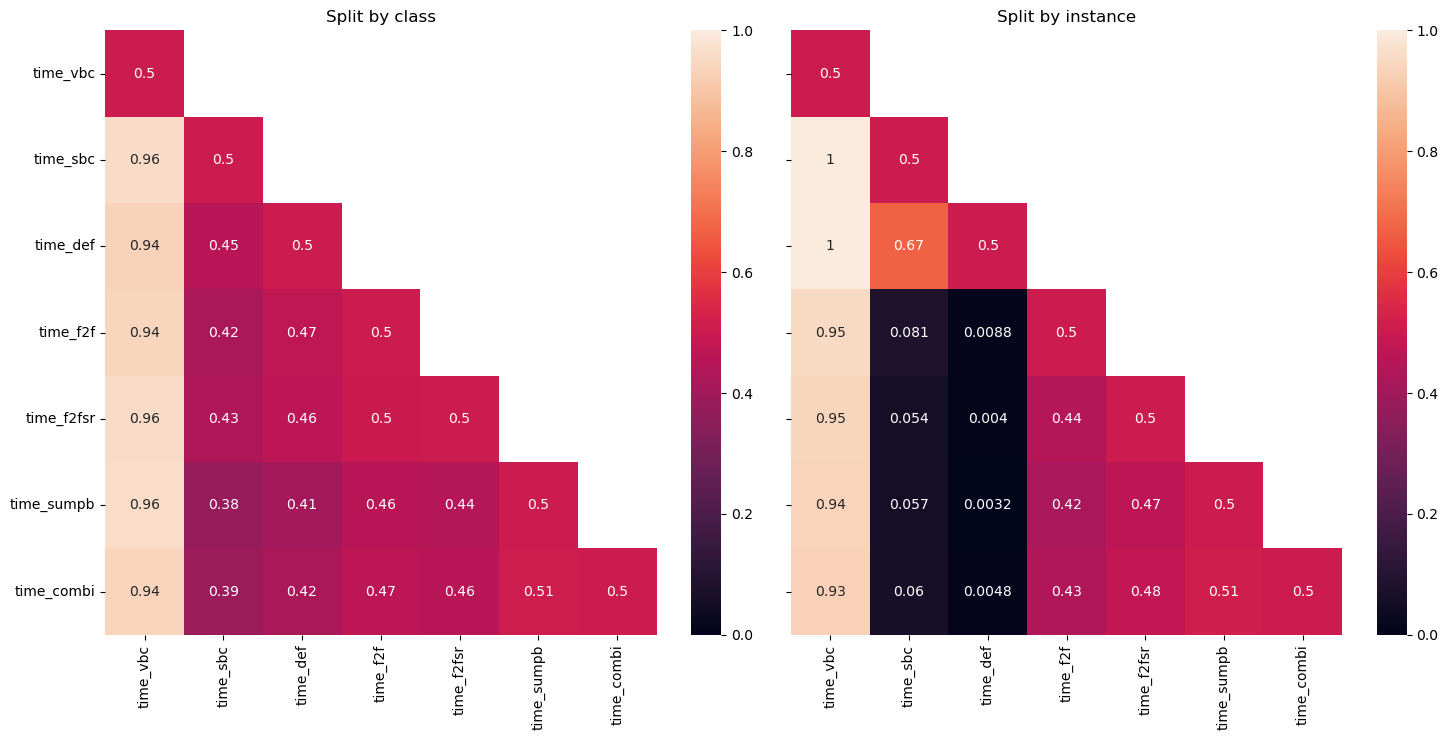

In [50]:
fig,axs = plt.subplots(1,2,figsize=(WID,0.5*WID), sharey=True)
for col in range(2):
    ax = axs[col]
    arr = effects[splits[col]]
    eff_df = pd.DataFrame(arr,index=t_cols,columns=t_cols)
    mask=np.zeros_like(arr)
    mask[np.triu_indices_from(mask,k=1)] = True
    g = sns.heatmap(eff_df, ax=ax, mask=mask, annot=True, vmin=0, vmax=1)
    ax.set(title="Split by "+splits[col])
fig.tight_layout()

## Wilcoxon Signed Rank

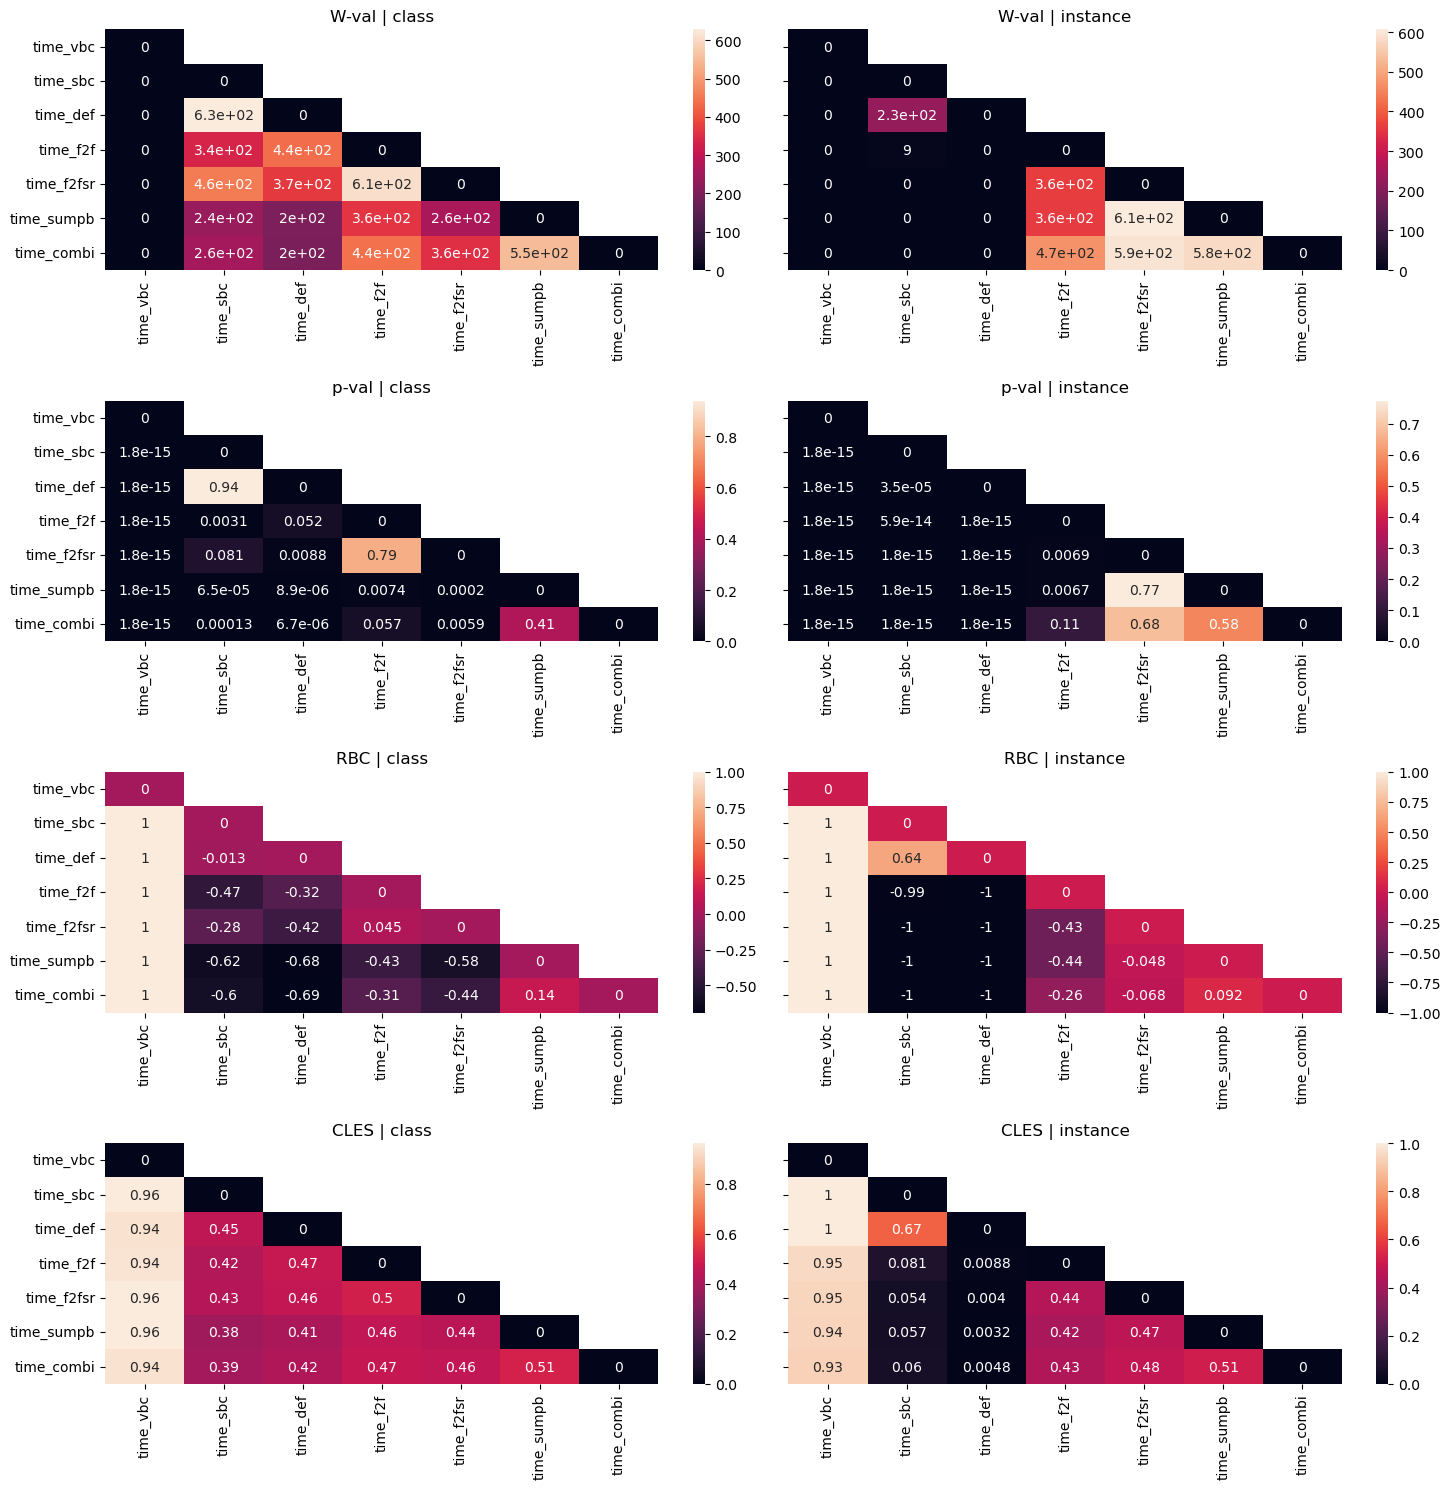

In [51]:
which_stat = [wsr_w_val,wsr_p_val, wsr_rbc, wsr_cles]
fig,axs = plt.subplots(4,2,figsize=(WID,WID), sharex=False, sharey=True)
for row,col in it.product(range(4),range(2)):
    ax = axs[row,col]
    st = which_stat[row]
    st_name = ['W-val','p-val','RBC','CLES'][row]
    arr = st[splits[col]]
    df = pd.DataFrame(arr,index=t_cols,columns=t_cols)
    mask=np.zeros_like(arr)
    mask[np.triu_indices_from(mask,k=1)] = True
    g = sns.heatmap(df, ax=ax, mask=mask, annot=True)
    ax.set(title=st_name + " | " + splits[col])
fig.tight_layout()